# Cross Validation Cycle

The process of cross validation is done to avoid __overfitting__ where the model adapts to given data and performs extremely well on it, and fails to generalize on other data.  
Usually, divide dataset into Train set(80%), dev set(10%), and test set

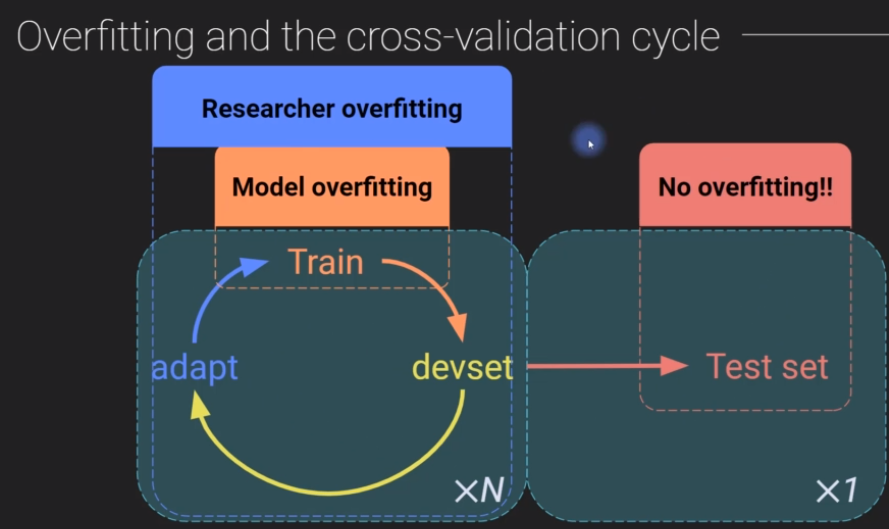

Train the model on train set ONLY.  
After training, test it on dev set / validation set. If model performance is not enough, change hyper parameters (number of layers, units, loss functions. optimizers, learning rates etc.)  
Keep doing the above two steps until the model performs adequately.  
Then, test it on Test set.

## Cross validation - Manual seperation

Manually seperating data into train and test using numpy on Iris dataset

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

In [2]:
def load_iris():
    iris = sns.load_dataset('iris')

    # Organizing the data
    data = torch.tensor(iris[iris.columns[:4]].values).float()

    # transforming species to numbers
    labels = torch.zeros(len(data), dtype=torch.long)
    # Let Setosa already imply 0
    labels[iris.species=='versicolor'] = 1
    labels[iris.species=='virginica'] = 2
    
    return data, labels

In [3]:
# no dev-set, only train and test
data,labels = load_iris()

propTrain = 0.8 # defining proportion of training data
nTrain = int(data.shape[0]*propTrain)

# initialize bool vector to select data and labels randomly
trainTestBool = np.zeros(data.shape[0], dtype=bool)

# true implies samples included in train set, else test set
trainTestBool[range(nTrain)] = True
trainTestBool

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False,

In [4]:
# test if it is balanced

print('Avg of full data:', torch.mean(labels.float()))
print('Avg of train data:', torch.mean(labels[trainTestBool].float()))
print('Avg of test data:', torch.mean(labels[~trainTestBool].float()))

Avg of full data: tensor(1.)
Avg of train data: tensor(0.7500)
Avg of test data: tensor(2.)


Average distribution is 1 in a perfectly balanced dataset, but it is not the case for train and test data. It is because the data is not randomized. Hence we select data randomly

In [5]:
# initialize bool vector to select data and labels randomly
trainTestBool = np.zeros(data.shape[0], dtype=bool)

trainData = np.random.choice(range(len(labels)), nTrain, replace=False)
trainTestBool[trainData] = True
trainTestBool

array([False,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True, False,  True,  True,  True,  True, False, False,
        True, False,  True,  True, False,  True,  True,  True,  True,
       False,  True,

In [6]:
# test if it is balanced

print('Avg of full data:', torch.mean(labels.float()))
print('Avg of train data:', torch.mean(labels[trainTestBool].float()))
print('Avg of test data:', torch.mean(labels[~trainTestBool].float()))

Avg of full data: tensor(1.)
Avg of train data: tensor(0.9750)
Avg of test data: tensor(1.1000)


Above distribution is better

In [7]:
print(data[trainTestBool].shape) # train set
print(data[~trainTestBool].shape) # test set

torch.Size([120, 4])
torch.Size([30, 4])


#### Training the model

In [8]:
MultiANN = nn.Sequential(
    nn.Linear(4, 64),    # ip layer
    nn.ReLU(),           # activation
    nn.Linear(64, 64),   # hidden Layer
    nn.ReLU(),           # activation
    nn.Linear(64, 3)     # op layer with 3 outputs, each implying a value with will be converted as probabilities by softmax
)

# loss function
# we haven't defined softmax layer above because the loss function below 
# automatically takes in the output values from NN and calculates 
# log softmax function of the ouputs before calculating the loss.
lossfn = nn.CrossEntropyLoss()

# optimizer
optim = torch.optim.SGD(MultiANN.parameters(), lr = 0.01)

In [9]:
nEp = 1000
losses = torch.zeros(nEp)
ongoingAcc = []

for i in range(nEp):
    
    #forward pass
    yHat = MultiANN(data[trainTestBool])
    # compute loss
    loss = lossfn(yHat, labels[trainTestBool])
    losses[i] = loss
    
    # backprop
    optim.zero_grad()
    loss.backward()
    optim.step()

In [10]:
# prediction for train data
pred = MultiANN(data[trainTestBool])
pred_labels = torch.argmax(pred, axis=1)
trainAcc = 100*torch.mean((pred_labels == labels[trainTestBool]).float())
print('Train Accuracy : %g%%' %trainAcc)


# prediction for test data
pred = MultiANN(data[~trainTestBool])
pred_labels = torch.argmax(pred, axis=1)
testAcc = 100*torch.mean((pred_labels == labels[~trainTestBool]).float())
print('Test Accuracy : %g%%' %testAcc)

Train Accuracy : 98.3333%
Test Accuracy : 96.6667%


## Cross Validation - scikit-learn

Also performing parametric experiment on proportional split of train and test

### Loading the data

In [11]:
data, labels = load_iris()

In [12]:
def createModel():
    MultiANN = nn.Sequential(
        nn.Linear(4, 64),    # ip layer
        nn.ReLU(),           # activation
        nn.Linear(64, 64),   # hidden Layer
        nn.ReLU(),           # activation
        nn.Linear(64, 3)     # op layer with 3 outputs, each implying a value with will be converted as probabilities by softmax
    )

    lossfn = nn.CrossEntropyLoss()

    # optimizer
    optim = torch.optim.SGD(MultiANN.parameters(), lr = 0.01)
    
    return MultiANN, lossfn, optim


nEp = 200

def trainModel(proportion):
    losses = torch.zeros(nEp)
    trainAcc = []
    testAcc = []
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size = proportion, shuffle=True)
    
    MultiANN, lossfn, optim = createModel()
    
    for i in range(nEp):
        
        yHat = MultiANN(X_train)
        loss = lossfn(yHat, y_train)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        trainAcc.append(100*torch.mean((torch.argmax(yHat, axis=1) == y_train).float()).item())
        
        
        pred = MultiANN(X_test)
        pred_labels = torch.argmax(pred, axis=1)
        testAcc.append(100*torch.mean((pred_labels == y_test).float()).item())
        
    return trainAcc, testAcc

In train loop, we are computing test accuracy. This doesn't lead to overfitting on test data because we are computing loss and backpropogating on test data, not train data.

In [13]:
trainAcc, testAcc = trainModel(0.8)

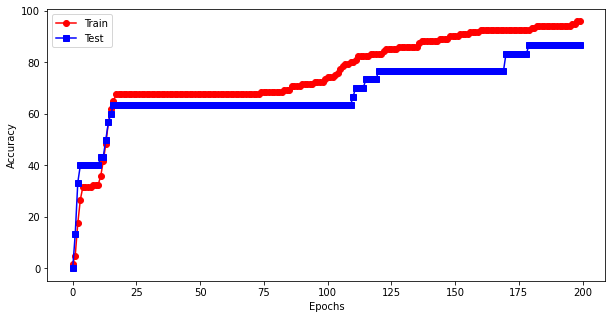

In [14]:
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc, 'ro-')
plt.plot(testAcc, 'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

In [15]:
prop = np.linspace(.2, .95, 10) # taking 10 proportional splits

allTrainAcc = np.zeros((len(prop), nEp))
allTestAcc = np.zeros((len(prop), nEp))

for i in range(len(prop)):
    
    MultiANN, lossfn, optim = createModel()
    
    trainAcc, testAcc = trainModel(prop[i])
    allTrainAcc[i, :] = trainAcc
    allTestAcc[i, :] = testAcc

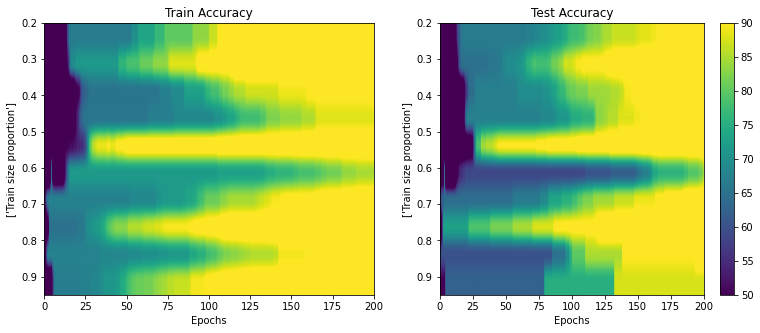

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(13,5))

p = ax[0].imshow(allTrainAcc, aspect='auto', vmin=50, vmax=90, extent=[
    0, nEp, prop[-1], prop[0]
])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel(['Train size proportion'])
ax[0].set_title('Train Accuracy')

# fig, ax = plt.subplots(1, 2, figsize=(13,5))

p = ax[1].imshow(allTestAcc, aspect='auto', vmin=50, vmax=90, extent=[
    0, nEp, prop[-1], prop[0]
])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel(['Train size proportion'])
ax[1].set_title('Test Accuracy')
fig.colorbar(p, ax=ax[1])
plt.show()

## Cross Validation - Dataloader

DataLoaders are iterables for large data. They are utilities provided by pytorch to make training process much faster. They divide data into batches of specified or default size (1) and make them training-ready

Trying out dataloaders with some fake data

In [17]:
# create our fake dataset

fakedata = np.tile(np.array([1,2,3,4]),(10,1)) + np.tile(10*np.arange(1,11),(4,1)).T
fakelabels = np.arange(10)>4
print(fakedata), print(' ')
print(fakelabels)

[[ 11  12  13  14]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 41  42  43  44]
 [ 51  52  53  54]
 [ 61  62  63  64]
 [ 71  72  73  74]
 [ 81  82  83  84]
 [ 91  92  93  94]
 [101 102 103 104]]
 
[False False False False False  True  True  True  True  True]


In [18]:
fakeDataLoader = DataLoader(fakedata, shuffle=True)
print(fakeDataLoader)
print(fakeDataLoader.batch_size)

1


In [19]:
for i, sample in enumerate(fakeDataLoader):
    print(i, sample, sample.shape)

0 tensor([[81, 82, 83, 84]]) torch.Size([1, 4])
1 tensor([[41, 42, 43, 44]]) torch.Size([1, 4])
2 tensor([[61, 62, 63, 64]]) torch.Size([1, 4])
3 tensor([[11, 12, 13, 14]]) torch.Size([1, 4])
4 tensor([[101, 102, 103, 104]]) torch.Size([1, 4])
5 tensor([[31, 32, 33, 34]]) torch.Size([1, 4])
6 tensor([[71, 72, 73, 74]]) torch.Size([1, 4])
7 tensor([[91, 92, 93, 94]]) torch.Size([1, 4])
8 tensor([[51, 52, 53, 54]]) torch.Size([1, 4])
9 tensor([[21, 22, 23, 24]]) torch.Size([1, 4])


The labels are not present. We don't directly provide data to DataLoaders. We create an intermediate form known as __Dataset__. To this Dataset, we provide data and labels.

We use __TensorDataset__ here which can be imported from __torch.utils.data__. Before providing to it, we should convert it to tensors using __torch.Tensor__.

In [20]:
fakeDataset = TensorDataset(torch.Tensor(fakedata), torch.Tensor(fakelabels))

print(fakeDataset.tensors)

(tensor([[ 11.,  12.,  13.,  14.],
        [ 21.,  22.,  23.,  24.],
        [ 31.,  32.,  33.,  34.],
        [ 41.,  42.,  43.,  44.],
        [ 51.,  52.,  53.,  54.],
        [ 61.,  62.,  63.,  64.],
        [ 71.,  72.,  73.,  74.],
        [ 81.,  82.,  83.,  84.],
        [ 91.,  92.,  93.,  94.],
        [101., 102., 103., 104.]]), tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]))


Now we provide this dataset to dataloader

In [21]:
fakeDataLoader = DataLoader(fakeDataset, shuffle=True)

for ip, lbl in fakeDataLoader:
    print(ip, lbl)

tensor([[91., 92., 93., 94.]]) tensor([1.])
tensor([[11., 12., 13., 14.]]) tensor([0.])
tensor([[31., 32., 33., 34.]]) tensor([0.])
tensor([[71., 72., 73., 74.]]) tensor([1.])
tensor([[81., 82., 83., 84.]]) tensor([1.])
tensor([[61., 62., 63., 64.]]) tensor([1.])
tensor([[101., 102., 103., 104.]]) tensor([1.])
tensor([[21., 22., 23., 24.]]) tensor([0.])
tensor([[41., 42., 43., 44.]]) tensor([0.])
tensor([[51., 52., 53., 54.]]) tensor([0.])


To create train and test dataloaders, we divide the data into train and test sets using sklearn, and then provide them to TensorDataset and then to Dataloaders:

In [22]:
X_train, X_test, y_train, y_test = train_test_split(fakedata, fakelabels, test_size=0.2, shuffle=True)

train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# give them to dataloaders
trainLoader = DataLoader(train_data, batch_size=4)
testLoader = DataLoader(test_data)

print('Train data:')
for ip, lbl in trainLoader:
    print(ip, lbl)

print('Test data:')
for ip, lbl in testLoader:
    print(ip, lbl)

Train data:
tensor([[101., 102., 103., 104.],
        [ 61.,  62.,  63.,  64.],
        [ 91.,  92.,  93.,  94.],
        [ 71.,  72.,  73.,  74.]]) tensor([1., 1., 1., 1.])
tensor([[41., 42., 43., 44.],
        [21., 22., 23., 24.],
        [51., 52., 53., 54.],
        [31., 32., 33., 34.]]) tensor([0., 0., 0., 0.])
Test data:
tensor([[11., 12., 13., 14.]]) tensor([0.])
tensor([[81., 82., 83., 84.]]) tensor([1.])


### Working on Iris data

In [23]:
data, labels = load_iris()

X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.8, shuffle=True)

train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# give them to dataloaders
trainLoader = DataLoader(train_data, batch_size=12)
# batch size for test data is total number of samples in test set, i.e. only one batch of all samples
testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [24]:
print('Train data:')
for ip, lbl in trainLoader:
    print(ip.shape, lbl.shape)

print('Test data:')
for ip, lbl in testLoader:
    print(ip.shape, lbl.shape)

Train data:
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
Test data:
torch.Size([30, 4]) torch.Size([30])


In [25]:
def createModel():
    MultiANN = nn.Sequential(
        nn.Linear(4, 64),    # ip layer
        nn.ReLU(),           # activation
        nn.Linear(64, 64),   # hidden Layer
        nn.ReLU(),           # activation
        nn.Linear(64, 3)     # op layer with 3 outputs, each implying a value with will be converted as probabilities by softmax
    )

    lossfn = nn.CrossEntropyLoss()

    # optimizer
    optim = torch.optim.SGD(MultiANN.parameters(), lr = 0.01)
    
    return MultiANN, lossfn, optim

In [26]:
nEp = 500

def trainModel():
    losses = torch.zeros(nEp)
    trainAcc = []
    testAcc = []
        
    MultiANN, lossfn, optim = createModel()
    
    # training loop
    for i in range(nEp):
        
        batchAcc = []
        
        # for each batch
        for inp, lbl in trainLoader:
            
            yHat = MultiANN(inp)
            loss = lossfn(yHat, lbl)

            optim.zero_grad()
            loss.backward()
            optim.step()

            batchAcc.append(100*torch.mean((torch.argmax(yHat, axis=1) == lbl).float()).item())
        # end of batch training
        
        # train accuracy
        trainAcc.append(np.mean(batchAcc))
        
        # test accuracy
        inp, lbl = next(iter(testLoader))
        pred = MultiANN(X_test)
        pred_labels = torch.argmax(pred, axis=1)
        testAcc.append(100*torch.mean((pred_labels == y_test).float()).item())
        
    return trainAcc, testAcc

In [27]:
trainAcc, testAcc = trainModel()

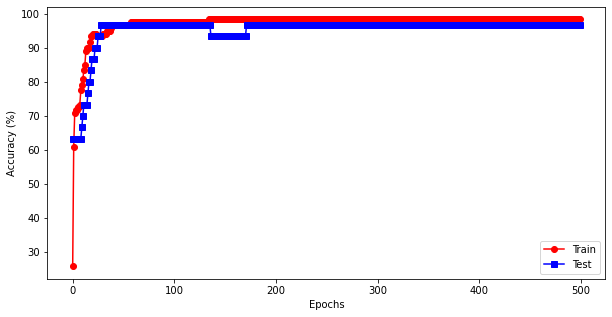

In [28]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'ro-')
plt.plot(testAcc,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])

# # optional zoom-in to final epochs
# plt.xlim([300,500])
# plt.ylim([90,100.5])

plt.show()

## Splitting into train, dev and test sets

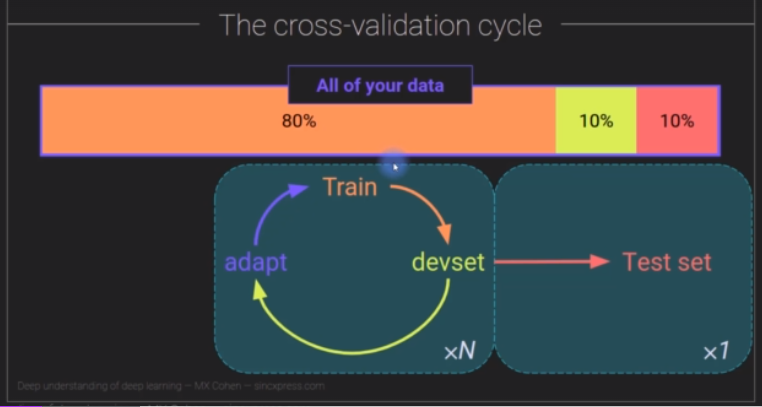

As simple as running train_test_split twice:

In [29]:
data, labels = load_iris()

# split into 90% train, and 10% test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, shuffle=True)

# split train data into 90% of train data into train and 10% val/dev
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1, shuffle=True)

print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)

torch.Size([121, 4])
torch.Size([14, 4])
torch.Size([15, 4])


You can also run the same by first dividing data into train and dev, and then dividing the dev into dev and test.

### Splitting the data using numpy

In [30]:
# train - 80, dev - 10, test - 10
part = np.array([.8, .1, .1])

# create Partition boundaries to decide final sample of each train, dev, test
partBound = np.cumsum(part*len(labels)).astype(int)
print('Partition boundaries:')
print(partBound)
print(' ')

# randomize the indices of labels to shuffle the data
randInd = np.random.permutation(range(len(labels)))
print('Randomized data indices:')
print(randInd)
print(' ')

Partition boundaries:
[120 135 150]
 
Randomized data indices:
[109  16   3  76  50 117  58  97  90  70  78  17 122 147  39 115 116 113
  98  56 140 138 121 134  66  53  13  73 126  27  72 108  69 131 110  49
  94 133  34  59  91  36  80   2 142 143  87  44 127  84 114 105  81 107
  25 137  48  14  29  96  32 118  89  79  51  68  88 136  77  40  15  95
  35   1  75  60  42  43  37 102 135  62 100  92  18  11  74  22 139  30
 130 123 125 128  26 149   0 106  28 112  31 104  54 145  99 129 103   9
  61   8 146   5 101  85   6  93  57  24 124  63  47 144  67  23  38  33
  83 119 141 148  46  86  10   4  20  19  55  21  64  12 132  65  52 111
   7  71  82 120  45  41]
 


In [31]:
# selecting rows for train data
trainData = data[randInd[:partBound[0]], :]
trainLabels = data[randInd[:partBound[0]]]

# selecting rows for dev data
devData = data[randInd[partBound[0]:partBound[1]], :]
devLabels = data[randInd[partBound[0]:partBound[1]]]

# selecting rows for test data
testData = data[randInd[partBound[1]:], :]
testLabels = data[randInd[partBound[1]:]]

In [32]:
print('Train data and labels shape:', trainData.shape, trainLabels.shape)
print('Dev data and labels shape:', devData.shape, devLabels.shape)
print('Test data and labels shape:', testData.shape, testLabels.shape)

Train data and labels shape: torch.Size([120, 4]) torch.Size([120, 4])
Dev data and labels shape: torch.Size([15, 4]) torch.Size([15, 4])
Test data and labels shape: torch.Size([15, 4]) torch.Size([15, 4])


## Cross Validation on Regression

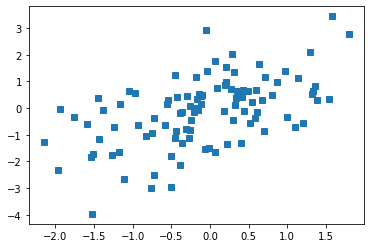

In [33]:
N = 100 # number of data points
x = torch.randn(N, 1)
y = x + torch.randn(N, 1)

plt.plot(x,y, 's')
plt.show()

In [34]:
# build model
ANNreg = nn.Sequential(
    nn.Linear(1,1),  # input layer
    nn.ReLU(),       # activation function
    nn.Linear(1,1)   # output layer
    )

learningRate = .05

# loss function
lossfun = nn.MSELoss()

# optimizer
optimizer = torch.optim.SGD(ANNreg.parameters(),lr=learningRate)

#### Selecting data for training

In [35]:
trainIdx = np.random.choice(range(N), 80, replace=False) # 80 random indices
trainBool = np.zeros(N, dtype=bool)
trainBool[trainIdx] = True

# train data
print(x[trainBool].shape)

# test data
print(x[~trainBool].shape)

torch.Size([80, 1])
torch.Size([20, 1])


In [36]:
# training the model
numepochs = 500
for epochi in range(numepochs):

  # forward pass
  yHat = ANNreg(x[trainBool])

  # compute loss
  loss = lossfun(yHat,y[trainBool])

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

In [37]:
# report the losses

# compute losses of the TEST set
predYtest = ANNreg(x[~trainBool])
testloss = (predYtest-y[~trainBool]).pow(2).mean()

# print out final TRAIN loss and TEST loss
print(f'Final TRAIN loss: {loss.detach():.2f}')
print(f'Final TEST loss: {testloss.detach():.2f}')

Final TRAIN loss: 1.01
Final TEST loss: 1.81


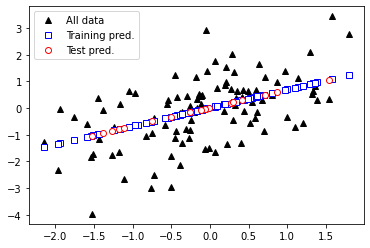

In [38]:
### plot the data

# predictions for final training run
predYtrain = ANNreg(x[trainBool]).detach().numpy()

# now plot
plt.plot(x,y,'k^',label='All data')
plt.plot(x[trainBool], predYtrain,
         'bs',markerfacecolor='w',label='Training pred.')
plt.plot(x[~trainBool],predYtest.detach(),
         'ro',markerfacecolor='w',label='Test pred.')
plt.legend()
plt.show()

#### Dividing the above data using sklearn and dataloaders

In [39]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8, shuffle=True)

train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# give them to dataloaders
trainLoader = DataLoader(train_data, batch_size=12)
# batch size for test data is total number of samples in test set, i.e. only one batch of all samples
testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [40]:
for inp, lbl in trainLoader:
    print(inp.shape, lbl.shape)

torch.Size([12, 1]) torch.Size([12, 1])
torch.Size([12, 1]) torch.Size([12, 1])
torch.Size([12, 1]) torch.Size([12, 1])
torch.Size([12, 1]) torch.Size([12, 1])
torch.Size([12, 1]) torch.Size([12, 1])
torch.Size([12, 1]) torch.Size([12, 1])
torch.Size([8, 1]) torch.Size([8, 1])


In [41]:
# training the model
numepochs = 500
trainLoss = []
testLoss = []

for epochi in range(numepochs):

    batchLoss = []
    
    for inp, lbl in trainLoader:
        
        # forward pass
        yHat = ANNreg(inp)

        # compute loss
        loss = lossfun(yHat,lbl)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        batchLoss.append((lbl-yHat).pow(2).mean().detach())
   
    trainLoss.append(np.mean(batchLoss))
    
    inp, lbl = next(iter(testLoader))
    pred = ANNreg(X_test)
    testLoss.append((lbl-pred).pow(2).mean().detach())


In [42]:
print('Final train Loss:', np.mean(trainLoss))
print('Final test Loss:', np.mean(testLoss))

Final train Loss: 1.2425219
Final test Loss: 1.2393268


# Regularization

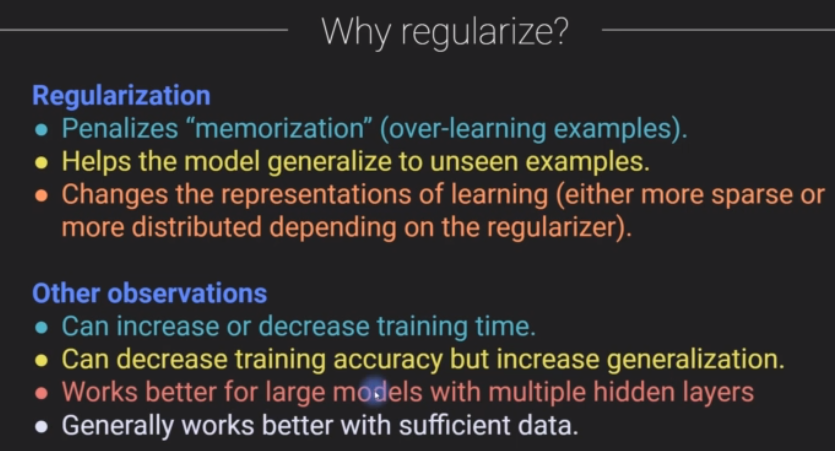

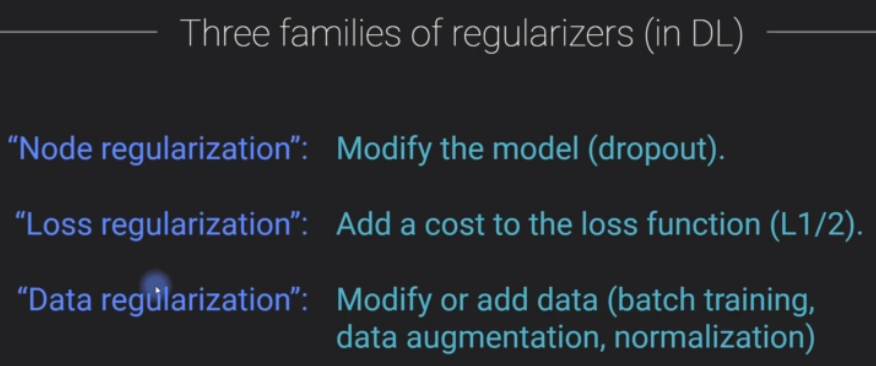

### Node regularization

It is done using a method called dropout which forces the nodes randomly to contribute nothing to the network. This is implemented by forcing the node activation to 0.

### Loss regularization

This is about adding something extra of value to cost function, which prevents the weights from getting too large.

### Data regularization

Data augmentation - Modify existing data to add more data. Usually done in images


## train() vs eval()

Gradients are computed only during backprop, not evaluation. Same goes  with some regularization method. Hence, we need to deactivate these activities while evaluating model performance.

say __net__ is a model:
- __net.train()__ - puts model in training mode. Regularization is active by default and is necessary for training. __it has to be reset if net.eval() was called before__.

- __net.eval()__ - puts in testing mode. Regularization is off, it is necessary when evaluating models with regularization.

- __torch.no_grad()__ - used during testing mode. Grdients are not computed

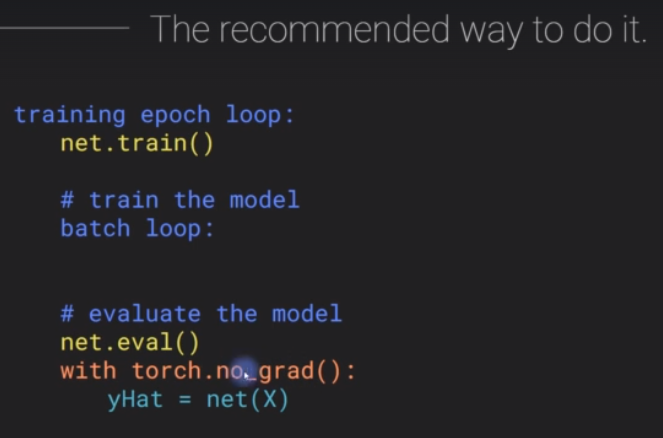

## Dropout Regularization

During training, at each epoch, we randomly pick nodes with probability __p__ and switch them off (force them to be 0), effectively dropping them off.

During evaluation or testing, __no dropout__ is carried out. However, since training happens with relatively fewer nodes, while testing, we scale the nodes down by multiplying their weights with __(1-p)__.

Alternatively, during training, the non-dropped nodes can be scaled __up__ by a probability of __q = 1/(1-p)__, and test them regularly. __(Pytorch implements this method)__.

__Why Dropout?__
- Prevents single node from learning too much
- Forces the model to have more distributed representations.
- Makes model less reliant on individual nodes.

It requires more training, can decrease accuracy but increase generalisation, works better on deep nets than shallow ones.

In [43]:
prob = 0.4 # probability of dropout

dropout = nn.Dropout(p=prob)
x = torch.ones(10)
print(x)

y = dropout(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1.6667, 0.0000, 1.6667, 1.6667, 0.0000, 0.0000, 1.6667, 0.0000, 1.6667,
        1.6667])
tensor(1.)


In [44]:
# turning off dropout on evaluation
dropout.eval()
y = dropout(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [45]:
# F.dropout() is not deactivated in eval mode

dropout.eval()
y = F.dropout(x)
print(y)
print(torch.mean(y))

tensor([0., 2., 2., 2., 2., 0., 2., 2., 0., 0.])
tensor(1.2000)


In [46]:
# can be switched off manually
y = F.dropout(x, training=False)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [47]:
# model needs to reset after toggling into eval mode

print(y) # still in eval mode
print(torch.mean(y))

dropout.train() # swtich to training mode
y = dropout(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)
tensor([0.0000, 0.0000, 1.6667, 1.6667, 1.6667, 1.6667, 1.6667, 0.0000, 0.0000,
        1.6667])
tensor(1.)


## Dropout in Practice

Also running a parametric experiment with different dropout rates

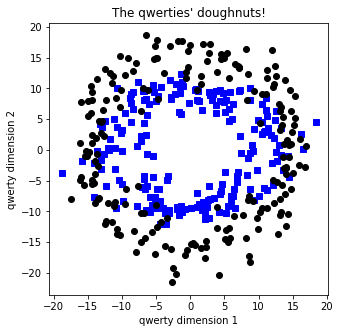

In [48]:
# create data

npc = 200

th = np.linspace(0,4*np.pi,npc) # theta/angle from 0-4*pi
r1 = 10 # internal radius
r2 = 15 # external radius

# generate data
a = [ r1*np.cos(th) + np.random.randn(npc)*3 ,
      r1*np.sin(th) + np.random.randn(npc) ]
b = [ r2*np.cos(th) + np.random.randn(npc) ,
      r2*np.sin(th) + np.random.randn(npc)*3 ]

# true labels
labels_np = np.vstack((np.zeros((npc,1)),np.ones((npc,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [49]:
# splitting data into dataLoaders

X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.8, shuffle=True)

train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# give them to dataloaders
batch_size = 16
trainLoader = DataLoader(train_data, batch_size=batch_size)
testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [50]:
# creating the model

class Model(nn.Module):
    def __init__(self, dropRate):
        super().__init__()
        
        #layers
        self.ip = nn.Linear(2, 128)
        self.hid = nn.Linear(128, 128)
        self.op = nn.Linear(128, 1)
        self.dr = dropRate # parameter
    
    def forward(self, x):
        x = F.relu(self.ip(x))
        x = F.dropout(x, p=self.dr, training=self.training) # 3rd param is set to True in train() mode, False in eval() mode
        x = F.relu(self.hid(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        x = self.op(x)
        
        return x

In [51]:
# test the model
tmpnet = Model(.25)

# run some random data through
tmpdata = torch.randn((10,2))
yhat = tmpnet(tmpdata)
yhat

tensor([[0.1227],
        [0.0694],
        [0.2386],
        [0.1148],
        [0.0209],
        [0.0693],
        [0.0117],
        [0.0252],
        [0.0903],
        [0.1512]], grad_fn=<AddmmBackward0>)

In [52]:
# Function to create and train model

def createModel(dr):
    ANN = Model(dr)
    
    lossfn = nn.BCEWithLogitsLoss()
    
    optim = torch.optim.SGD(ANN.parameters(), lr = 0.02)
    
    return ANN, lossfn, optim

In [53]:
nEp = 1000

def trainModel(ANN, lossfn, optim):
    trainAcc = []
    testAcc = []
    
    for i in range(nEp):
        ANN.train() # setting in train mode
        
        batchAcc = []
        
        for x, y in trainLoader:
            yHat = ANN(x)
            loss = lossfn(yHat, y)
            
            #backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        
        trainAcc.append(np.mean(batchAcc))
        
        ANN.eval() # setting in eval mode
        
        x, y =next(iter(testLoader))
        yHat = ANN(x)
        testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        
    return trainAcc, testAcc

In [54]:
dr = .0

ANN, lossfn, optim = createModel(dr)
trainAcc, testAcc = trainModel(ANN, lossfn, optim)

In [55]:
# create a 1D smoothing filter
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')

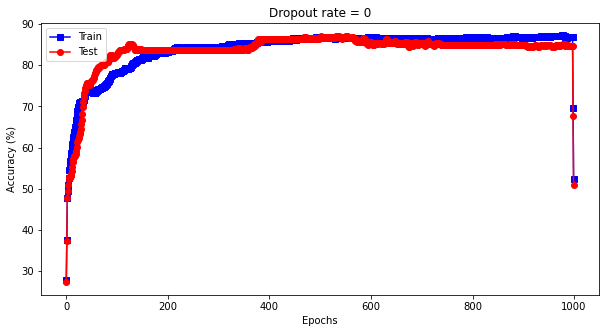

In [56]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(smooth(trainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')
# plt.plot(trainAcc,'bs-')
# plt.plot(testAcc,'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dr)

plt.show()

### Experiment

In [57]:
dr = np.arange(10)/10
res = np.zeros((len(dr), 2))

for i in range(len(dr)):
    ANN, lossfn, optim = createModel(dr[i])
    trainAcc, testAcc = trainModel(ANN, lossfn, optim)
    
    # taking results from last 100 epochs
    res[i, 0] = np.mean(trainAcc[-100])
    res[i, 1] = np.mean(testAcc[-100])

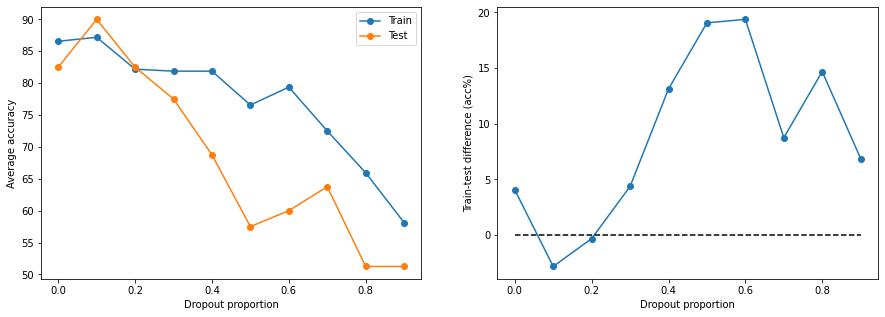

In [58]:
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dr,res,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dr,-np.diff(res,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

#### Another experiment of dropout with IRIS dataset

In [59]:
data, labels = load_iris()

X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.8, shuffle=True)

train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# give them to dataloaders
trainLoader = DataLoader(train_data, batch_size=16)
# batch size for test data is total number of samples in test set, i.e. only one batch of all samples
testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [60]:
# creating the model

class ModelIris(nn.Module):
    def __init__(self, dropRate):
        super().__init__()
        
        #layers
        self.input  = nn.Linear( 4,12)
        self.hidden = nn.Linear(12,12)
        self.output = nn.Linear(12, 3)
        self.dr = dropRate # parameter
    
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.dropout(x, p=self.dr, training=self.training) # 3rd param is set to True in train() mode, False in eval() mode
        x = F.relu(self.hidden(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        x = self.output(x)
        
        return x

# Function to create and train model

def createModel(dr):
    ANNIris = ModelIris(dr)
    
    lossfn = nn.CrossEntropyLoss()
    
    optim = torch.optim.SGD(ANNIris.parameters(), lr = 0.05)
    
    return ANNIris, lossfn, optim


nEp = 500

def trainModelIris(ANNIris, lossfn, optim):
    trainAcc = []
    testAcc = []
    
    for i in range(nEp):
        ANN.train() # setting in train mode
        
        batchAcc = []
        
        for x, y in trainLoader:
            yHat = ANNIris(x)
            
            loss = lossfn(yHat, y)
            
            #backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
        
        trainAcc.append(np.mean(batchAcc))
        
        ANN.eval() # setting in eval mode
        
        x, y =next(iter(testLoader))
        pred_labels = torch.argmax(ANNIris(x), axis=1)
        testAcc.append(100*torch.mean((pred_labels == y_test).float()).item())

        
    return trainAcc, testAcc

In [61]:
dr = .0

ANNIris, lossfn, optim = createModel(dr)
trainAcc, testAcc = trainModelIris(ANNIris, lossfn, optim)

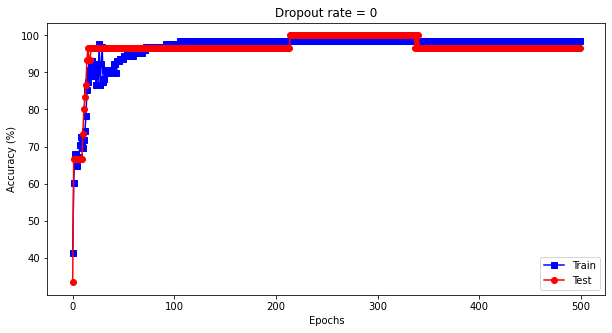

In [62]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs-')
plt.plot(testAcc,'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dr)

plt.show()

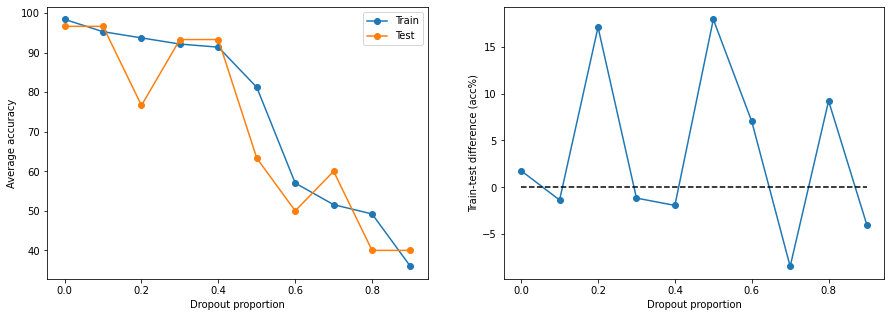

In [63]:
dr = np.arange(10)/10
res = np.zeros((len(dr), 2))

for i in range(len(dr)):
    ANNIris, lossfn, optim = createModel(dr[i])
    trainAcc, testAcc = trainModelIris(ANNIris, lossfn, optim)
    
    # taking results from last 100 epochs
    res[i, 0] = np.mean(trainAcc[-100])
    res[i, 1] = np.mean(testAcc[-100])

# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dr,res,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dr,-np.diff(res,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

## L1 and L2 Regularization


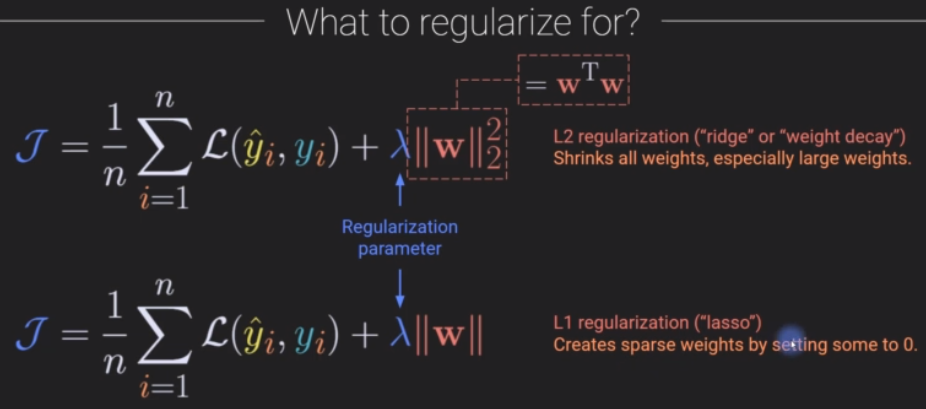

### L2 regularization implementation

In [64]:
data, labels = load_iris()

X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.8, shuffle=True)

train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# give them to dataloaders
trainLoader = DataLoader(train_data, batch_size=16)
# batch size for test data is total number of samples in test set, i.e. only one batch of all samples
testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [65]:
def createNewModel(L2lambda):
    
    ANNIris = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
    )
    
    lossfn = nn.CrossEntropyLoss()
    
    # providing regularization in optimizer
    optim = torch.optim.SGD(ANNIris.parameters(), lr = 0.005, weight_decay=L2lambda)
    
    return ANNIris, lossfn, optim

In [66]:
nEp = 500

def trainModel():
    trainAcc = []
    testAcc = []
    losses = []
    
    for i in range(nEp):
        
        ANNIris.train()
        batchAcc = []
        batchloss = []
        
        # batch loop
        for x, y in trainLoader:
            yHat = ANNIris(x)
            loss = lossfn(yHat, y)
            
            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item())
            batchLoss.append(loss.item())
        
        # train accuracy
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))
        
        # test accuracy
        ANNIris.eval()
        x, y = next(iter(testLoader))
        predLabels = torch.argmax(ANNIris(x), axis=1) 
        testAcc.append(100*torch.mean((predLabels == y).float()).item())
        
    return trainAcc, testAcc, losses

In [74]:
L2lambda = 0.1

ANNIris, lossfn, optim = createNewModel(L2lambda)
trainAcc, testAcc, losses = trainModel()

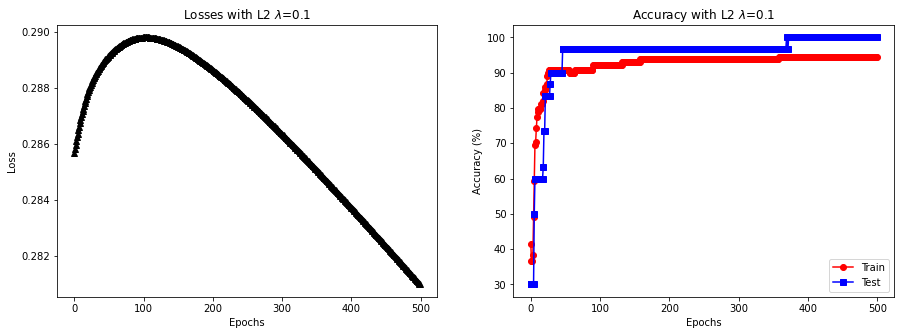

In [75]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [69]:
# experiment

L2lambdas = np.linspace(0, 0.1, 10)

AccTrain = np.zeros((nEp, len(L2lambdas)))
AccTest = np.zeros((nEp, len(L2lambdas)))

# create a 1D smoothing filter
def smooth(x,k):
    return np.convolve(x,np.ones(k)/k,mode='same')

for i in range(len(L2lambdas)):
    ANNIris, lossfn, optim = createNewModel(L2lambdas[i])
    trainAcc, testAcc, losses = trainModel()
    
    AccTrain[:,i] = smooth(trainAcc,10)
    AccTest[:,i]  = smooth(testAcc,10)

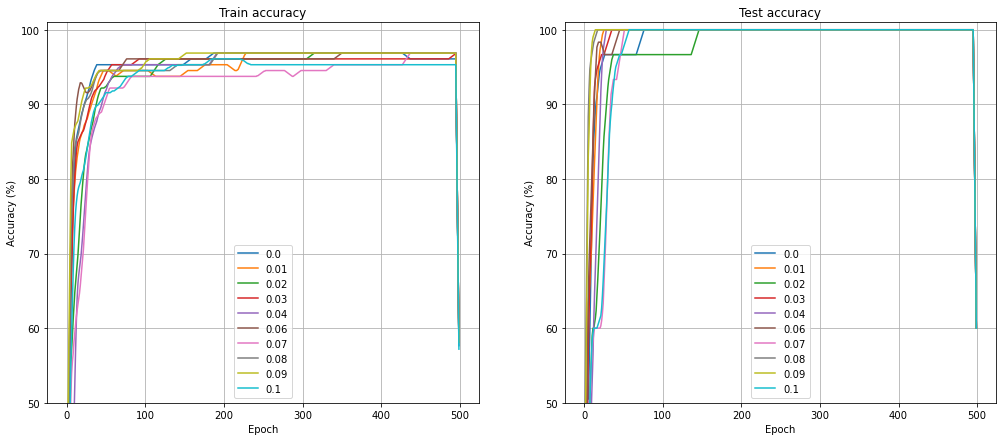

In [70]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(AccTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(AccTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,2) for i in L2lambdas]

# common features
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()

plt.show()

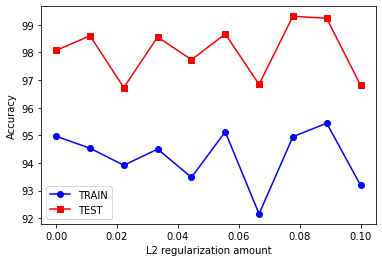

In [71]:
# show average accuracy by L2 rate

# average only some epochs
epoch_range = [0,500]


plt.plot(L2lambdas,
         np.mean(AccTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(L2lambdas,
         np.mean(AccTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### L1 Regularization

Not as easy as implementing L2 regularization

In [121]:
data, labels = load_iris()

X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.8, shuffle=True)

train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# give them to dataloaders
trainLoader = DataLoader(train_data, batch_size=16)
# batch size for test data is total number of samples in test set, i.e. only one batch of all samples
testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [122]:
# creating the model
def createNewModel():
    
    ANNIris = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
    )
    
    lossfn = nn.CrossEntropyLoss()
    
    optim = torch.optim.SGD(ANNIris.parameters(), lr = 0.005)
    
    return ANNIris, lossfn, optim

#### Accessing model weights

This would be required for us to manually add L1 regularization to model's weights

In [123]:
# explore the model in more detail
tmpmodel = createNewModel()[0]

# print the model architecture
print(tmpmodel)

# print the model's parameters
for i in tmpmodel.named_parameters():
    print(i[0],i[1].shape,i[1].numel())

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


In [124]:
# train the model
nEp = 1000

def trainModel(L1lambda, ANNIris, lossfn, optim):
    trainAcc = []
    testAcc = []
    losses = []
    
    # count total number of weights in model
    nWeights = 0
    for pname, weight in ANNIris.named_parameters():
        nWeights += weight.numel() # adding number of trainable params i.e. weights
    
    # training loop
    for i in range(nEp):
        
        ANNIris.train()
        batchAcc = []
        batchloss = []
        
        # batch loop
        for x, y in trainLoader:
            yHat = ANNIris(x)
            loss = lossfn(yHat, y)
            
            # Adding L1 term
            L1_term = torch.tensor(0., requires_grad=True)
            
            # sum all abs(weights)
            for pname, weight in ANNIris.named_parameters():
                if 'bias' not in pname:
                    L1_term = L1_term + torch.sum(torch.abs(weight))
                
            # add it to loss term
            loss += L1lambda*L1_term/nWeights
            
            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item())
            batchLoss.append(loss.item())
        
        # train accuracy
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))
        
        # test accuracy
        ANNIris.eval()
        x, y = next(iter(testLoader))
        predLabels = torch.argmax(ANNIris(x), axis=1) 
        testAcc.append(100*torch.mean((predLabels == y).float()).item())
        
    return trainAcc, testAcc, losses

In [125]:
# create a model
ANNIris,lossfn, optim = createNewModel()

# train the model
L1lambda = .001
trainAcc,testAcc,losses = trainModel(L1lambda, ANNIris, lossfn, optim)

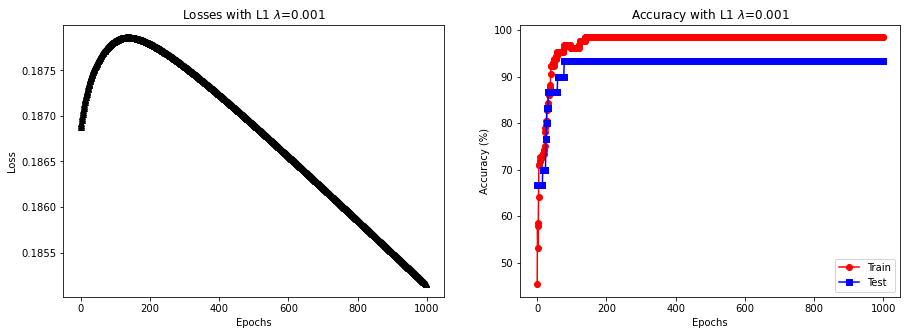

In [126]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L1lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [127]:
# experiment

L1lambdas = np.linspace(0, 0.005, 10)

AccTrain = np.zeros((nEp, len(L1lambdas)))
AccTest = np.zeros((nEp, len(L1lambdas)))

# create a 1D smoothing filter
def smooth(x,k):
    return np.convolve(x,np.ones(k)/k,mode='same')

for i in range(len(L2lambdas)):
    ANNIris, lossfn, optim = createNewModel()
    trainAcc, testAcc, losses = trainModel(L1lambdas[i], ANNIris, lossfn, optim)
    
    AccTrain[:,i] = smooth(trainAcc,10)
    AccTest[:,i]  = smooth(testAcc,10)

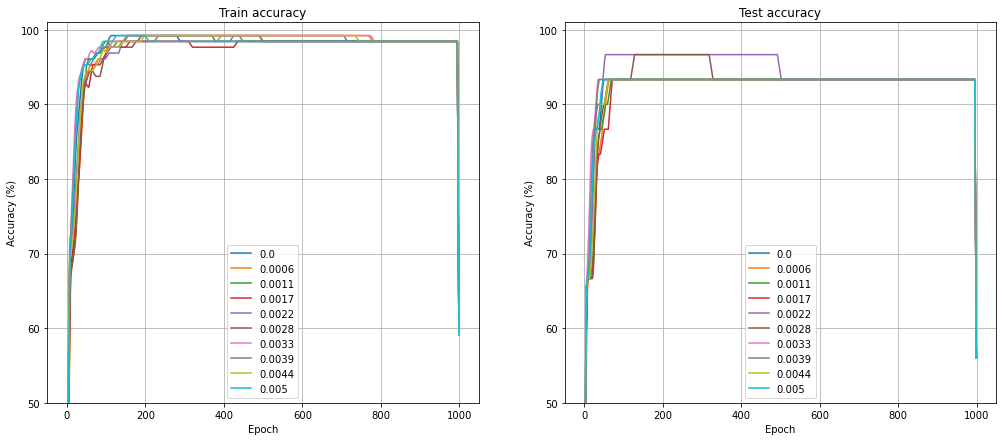

In [128]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(AccTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(AccTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,4) for i in L1lambdas]

# common features
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

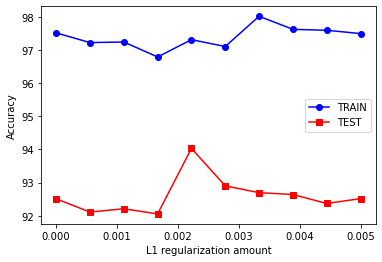

In [130]:
# show average accuracy by L1 rate

# average only some epochs
epoch_range = [0,950]


plt.plot(L1lambdas,
         np.mean(AccTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(L1lambdas,
         np.mean(AccTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Regularization - Mini batches

mini batches are subset of data (often non-overlapping). Size is often the powers of 2, between 2 to 512.  
Training in batches can decrease computation time (matrix multiplication instead of for loops). It can increase computation time for large batches and large data samples (eg - images).  
Batching is also a form of regularization as it smoothens the learning by averaging the loss over many samples, thereby reducing overfitting.

### Batch training - implementation

In [131]:
iris = sns.load_dataset('iris')

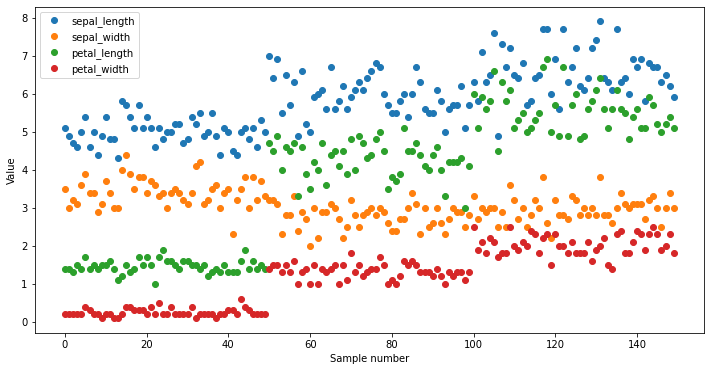

In [132]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [134]:
data, labels = load_iris()

X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.8, shuffle=True)

train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# give them to dataloaders
trainLoader = DataLoader(train_data, batch_size=16)
# batch size for test data is total number of samples in test set, i.e. only one batch of all samples
testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [136]:
for X,y in trainLoader:
  print(X.shape,y.shape)

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([8, 4]) torch.Size([8])


Since final batch is not of the same size as previous, we can have the option of dropping it to have consistency in batches for training:

In [140]:
# dropping last batch if it is inconsistent
trainLoader = DataLoader(train_data, batch_size=16, drop_last=True)

for X,y in trainLoader:
  print(X.shape,y.shape)

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


Rest of the process of training is same. We can experiment the training process with different batch sizes to analyse the performances